In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
sber_data = pd.read_csv('data/sber_data.csv', sep=',')
display(sber_data['ecology'].value_counts())

ecology
poor            8018
no data         7656
good            7174
excellent       3938
satisfactory    3685
Name: count, dtype: int64

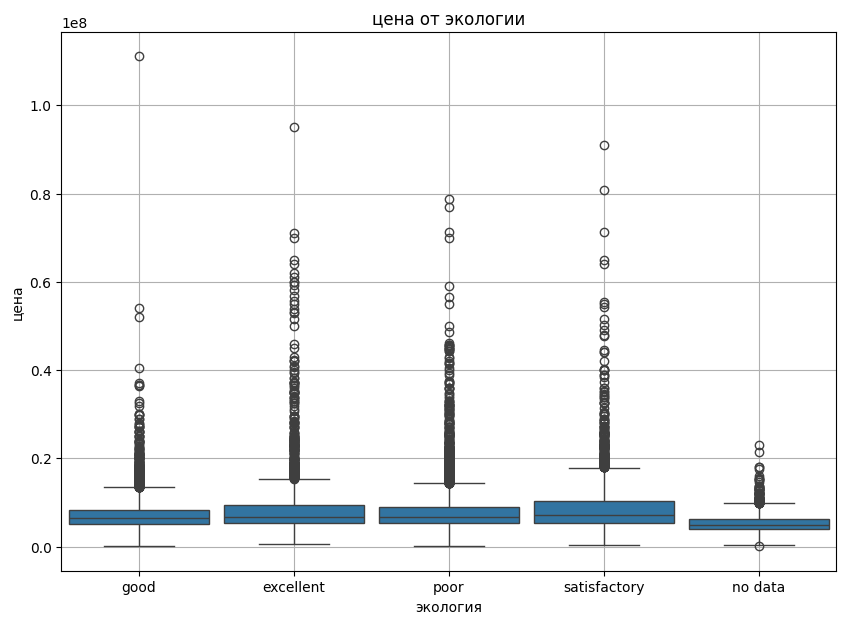

In [15]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=sber_data,
    y='price_doc',
    x='ecology',
    orient='v',
    width=0.9
)
boxplot.set_title('цена от экологии');
boxplot.set_xlabel('экология');
boxplot.set_ylabel('цена');
boxplot.grid()

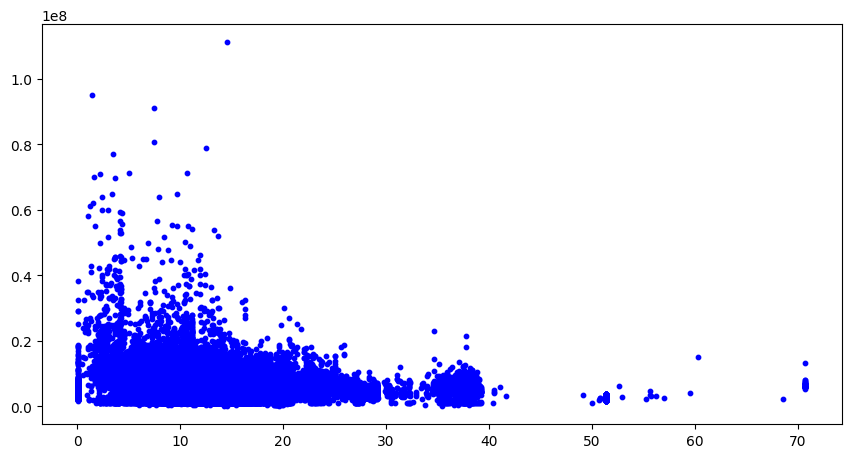

In [16]:
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(
    x=sber_data['kremlin_km'], 
    y=sber_data['price_doc'], 
    s=10,
    marker='o',
    c = 'blue'
)


In [17]:
cols_null_percent = sber_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

hospital_beds_raion          47.392603
preschool_quota              21.948738
school_quota                 21.938893
life_sq                      20.947786
floor                         0.548062
metro_min_walk                0.082045
metro_km_walk                 0.082045
railroad_station_walk_km      0.082045
railroad_station_walk_min     0.082045
dtype: float64

<Axes: title={'center': 'Распределение пропусков в данных'}>

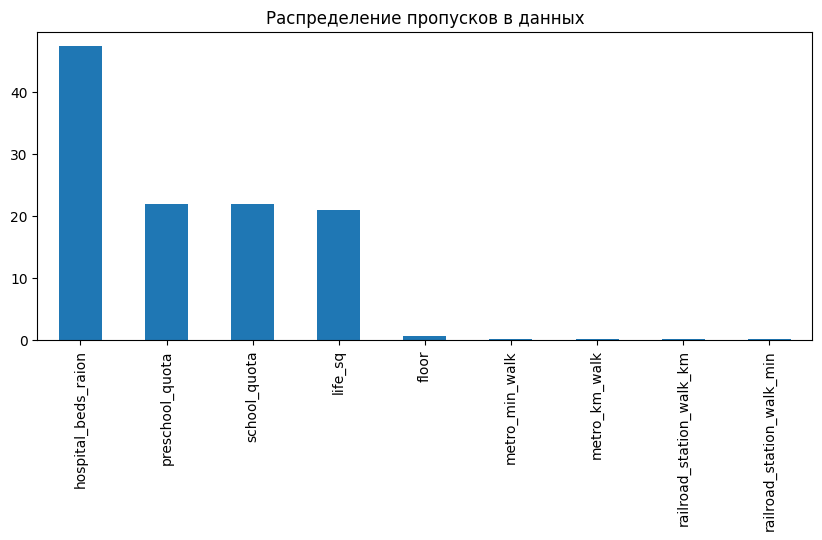

In [18]:
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
)

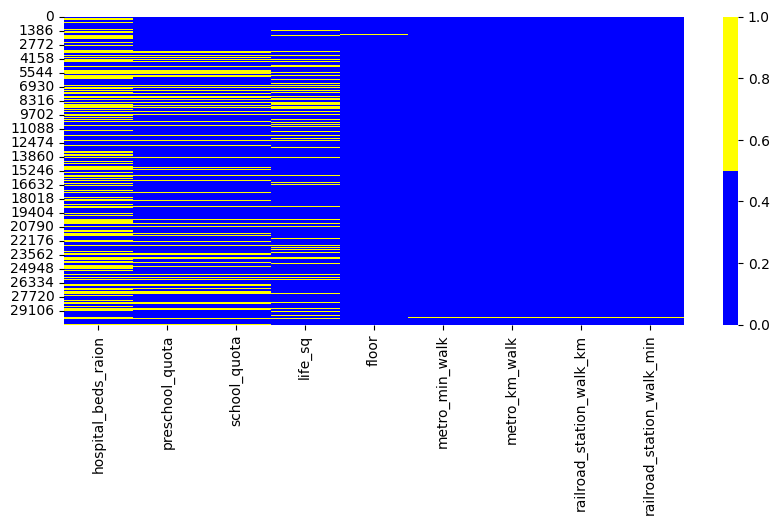

In [19]:
colors = ['blue', 'yellow'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    sber_data[cols].isnull(),
    cmap=sns.color_palette(colors),
)

In [20]:
combine_data = sber_data.copy()

#отбрасываем столбцы с числом пропусков более 30% (100-70)
n = combine_data.shape[0] #число строк в таблице
thresh = n*0.7
combine_data = combine_data.dropna(thresh=thresh, axis=1)

#отбрасываем строки с числом пропусков более 2 в строке
m = combine_data.shape[1] #число признаков после удаления столбцов
combine_data = combine_data.dropna(thresh=m-2, axis=0)

#создаём словарь 'имя_столбца' : число (признак), на которое (который) надо заменить пропуски 
values = {
    'life_sq': combine_data['full_sq'],
    'metro_min_walk': combine_data['metro_min_walk'].median(),
    'metro_km_walk': combine_data['metro_km_walk'].median(),
    'railroad_station_walk_km': combine_data['railroad_station_walk_km'].median(),
    'railroad_station_walk_min': combine_data['railroad_station_walk_min'].median(),
    'preschool_quota': combine_data['preschool_quota'].mode()[0],
    'school_quota': combine_data['school_quota'].mode()[0],
    'floor': combine_data['floor'].mode()[0]
}
#заполняем оставшиеся записи константами в соответствии со словарем values
combine_data = combine_data.fillna(values)
#выводим результирующую долю пропусков
display(combine_data.isnull().mean())

id                                       0.0
full_sq                                  0.0
life_sq                                  0.0
floor                                    0.0
sub_area                                 0.0
preschool_quota                          0.0
preschool_education_centers_raion        0.0
school_quota                             0.0
school_education_centers_raion           0.0
school_education_centers_top_20_raion    0.0
healthcare_centers_raion                 0.0
university_top_20_raion                  0.0
sport_objects_raion                      0.0
additional_education_raion               0.0
culture_objects_top_25_raion             0.0
shopping_centers_raion                   0.0
office_raion                             0.0
oil_chemistry_raion                      0.0
railroad_terminal_raion                  0.0
nuclear_reactor_raion                    0.0
metro_min_avto                           0.0
metro_km_avto                            0.0
metro_min_

In [21]:
combine_data.shape

(26800, 60)

In [32]:
def outliers_iqr_mod(data, feature, left=3, right=3, log_scale=False):
    

    if log_scale:
        x = np.log(data[feature])
    else:
        x = data[feature]
    
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75)
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)

    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [27]:
def outliers_z_score_mod(data, feature, log_scale=False, left = 3.7, right = 3.7):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

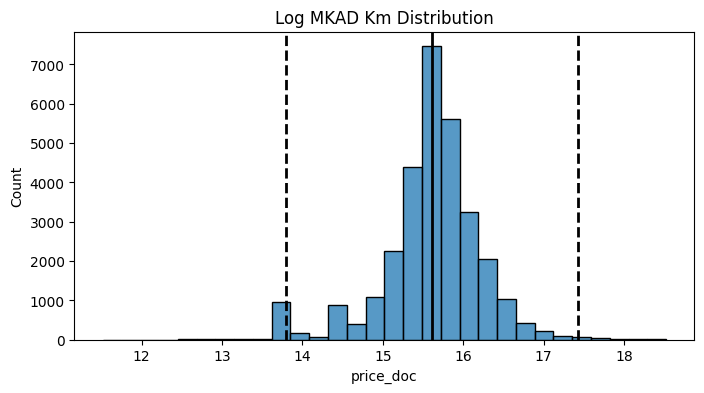

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_price_doc = np.log(sber_data['price_doc'] + 1)
histplot = sns.histplot(log_price_doc, bins=30, ax=ax)
histplot.axvline(log_price_doc.mean(), color='k', lw=2)
histplot.axvline(log_price_doc.mean()+ 3 * log_price_doc.std(), color='k', ls='--', lw=2)
histplot.axvline(log_price_doc.mean()- 3 * log_price_doc.std(), color='k', ls='--', lw=2)
histplot.set_title('Log MKAD Km Distribution');

In [33]:
outliers, cleaned = outliers_iqr_mod(sber_data, 'price_doc', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу z-отклонения: 92
Результирующее число записей: 30379
